In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7f4a4c4f-fd8e-66b0-3e59-d87889e0ed63)


In [2]:
!wget https://raw.githubusercontent.com/mufaddalhamidofficial/tensorflow_course/main/helper.py

--2024-01-15 13:44:27--  https://raw.githubusercontent.com/mufaddalhamidofficial/tensorflow_course/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11873 (12K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  11.59K  --.-KB/s    in 0s      

2024-01-15 13:44:27 (74.7 MB/s) - ‘helper.py’ saved [11873/11873]



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import cv2
import tensorflow_datasets as tfds

/Users/mufaddalhamid/Documents/Learn/TensorFlow/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from helper import create_tensorboard_callback, load_and_prep_image, create_checkpoint_callback, plot_loss_curves, compare_historys

In [3]:
dataset_lists = tfds.list_builders()

2024-01-15 20:01:20.679653: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [4]:
'food101' in dataset_lists

True

In [5]:
(train_data, test_data), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 121.14 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 80.53 url/s] 
2024-01-15 20:02:49.658748: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-15 20:02:49.658787: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-15 20:02:49.658790: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-15 20:02:49.658913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-15 20:02:49.659578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, nam

Dataset food101 downloaded and prepared to /Users/mufaddalhamid/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/var/folders/rk/0v2wchws66x_ly7s8h2s449r0000gn/T/tmp7j39rhoctfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [7]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

## Visualize Data

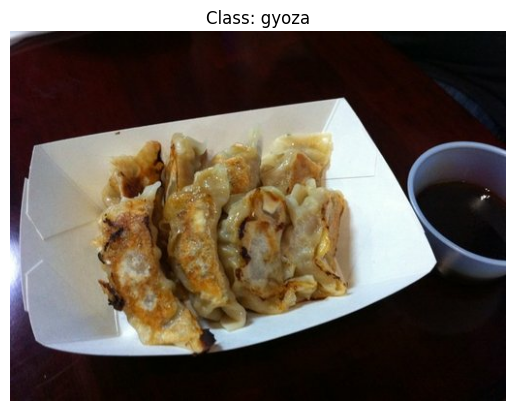

In [16]:
for image, label in train_data.take(1):
  plt.imshow(image)
  plt.title(f"Class: {class_names[label]}")
  plt.axis(False);

## Preprocess Data

In [17]:
def preprocess_img(img, label, img_shape = IMG_SIZE[0], scale = False):
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    img = img / 255.0
  return tf.cast(img, dtype=tf.float32), label

In [18]:
for image, label in train_data.take(1):
  print(preprocess_img(image, label));

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[2.52448978e+01, 1.22448978e+01, 4.72959232e+00],
        [3.24081612e+01, 1.94081631e+01, 1.14081631e+01],
        [3.27193871e+01, 1.97193871e+01, 1.07193871e+01],
        ...,
        [3.90050926e+01, 2.09948616e+01, 3.49997830e+00],
        [3.63112297e+01, 1.93112297e+01, 2.11736846e+00],
        [3.64132767e+01, 2.00000343e+01, 4.00003481e+00]],

       [[1.98979568e+01, 6.89795780e+00, 1.83672667e-01],
        [2.89438782e+01, 1.59438782e+01, 7.94387770e+00],
        [2.21122437e+01, 9.11224365e+00, 1.11224365e+00],
        ...,
        [4.88979416e+01, 2.70152836e+01, 6.14283562e+00],
        [4.46428452e+01, 2.38520279e+01, 3.07144165e+00],
        [4.27602005e+01, 2.19540844e+01, 3.07142830e+00]],

       [[2.02091827e+01, 7.20918369e+00, 6.47959292e-01],
        [2.27295933e+01, 9.72959328e+00, 2.27040911e+00],
        [2.65765305e+01, 1.35765314e+01, 5.57653141e+00],
        ...,
        [5.84540634e+01, 2.9596

## Batch and preprocess data

In [19]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and turn into batches and prefetch
train_data = train_data.shuffle(buffer_size=3000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Work on test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating Callbacks

## Mixed precision Training

In [23]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  METAL, no compute capability (probably not an Nvidia GPU)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Building feature extraction model

In [29]:
input_shape = IMG_SIZE + (3,)


base_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation(activation="softmax", dtype = tf.float32)(x)
model_b_1 = tf.keras.Model(inputs, outputs)

model_b_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)



In [30]:
model_b_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 101)               155237    
                                                                 
 activation_2 (Activation)   (None, 101)               0         
                                                                 
Total params: 13085859 (49.92 MB)
Trainable params: 155237 

In [31]:
for layer in model_b_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b3 False float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
activation_2 True float32 <Policy "float32">


In [32]:
history_1 = model_b_1.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        create_tensorboard_callback("tensorboard", "07_baseline_1"),
        create_checkpoint_callback("checkpoints", "07_baseline_1"),
    ],
)

Saving TensorBoard log files to: tensorboard/07_baseline_1/20240115-200806
Saving model checkpoints to: checkpoints/07_baseline_1/checkpoint.ckpt
Epoch 1/3


2024-01-15 20:08:10.727381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 1068s 446ms/step - loss: 1.7253 - accuracy: 0.5930 - val_loss: 1.1514 - val_accuracy: 0.6907
Epoch 2/3
2368/2368 [==============================] - 1072s 452ms/step - loss: 1.2086 - accuracy: 0.6840 - val_loss: 1.0347 - val_accuracy: 0.7116
Epoch 3/3
2368/2368 [==============================] - 1092s 460ms/step - loss: 1.0491 - accuracy: 0.7210 - val_loss: 0.9931 - val_accuracy: 0.7240


In [33]:
evaluation_b_1 = model_b_1.evaluate(test_data)

790/790 [==============================] - 332s 420ms/step - loss: 1.0223 - accuracy: 0.7225


In [34]:
model_b_1.save("models/07_baseline_1")

INFO:tensorflow:Assets written to: models/07_baseline_1/assets


INFO:tensorflow:Assets written to: models/07_baseline_1/assets
